In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [61]:
images = np.load("data/images.npy")
labels = np.load("data/labels.npy")

In [62]:
print(f"Images Shape: {images.shape}") 
print(f"Labels Shape: {labels.shape}")  

Images Shape: (1000, 16, 16)
Labels Shape: (1000,)


In [63]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
print(f"Unique Labels: {unique_labels}")
print(f"Label Counts: {label_counts}")

Unique Labels: [0 1]
Label Counts: [500 500]


### Observations
- There are only two labels in this dataset which are *0* and *1*. This shows that it is a **binary classification problem**.
- Each label appears 500 times. This shows that the dataset is perfectly balanced.
- There is no need for **class weighting, oversampling, or undersampling**, as both classes have equal representation.

## Dataset Description

- The dataset consists of **1000 grayscale images**, each of size **16x16 pixels**.
- Each image belongs to one of **two labels**:
  - **Label 0**: Background (No clear structure, scattered noise).
  - **Label 1**: Object (Brighter regions, structured patterns).
- Since each class appears **500 times**, this dataset is **balanced**, meaning no need for oversampling or class weighting.


### Exploratory Data Analysis(EDA)

### Step 1

First I will visualise sample images to see how the different labelled images are different from each other and how are they different

This is done below

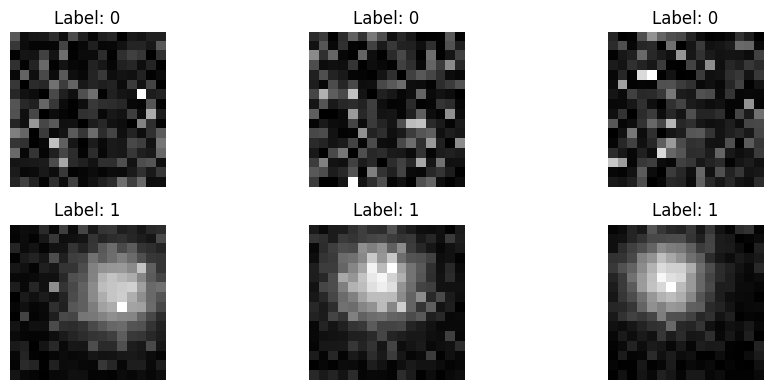

In [64]:
plt.figure(figsize=(10, 4))

# Find indices of label 0 and label 1
idx_0 = np.where(labels == 0)[0][:3]  # First 3 samples of class 0
idx_1 = np.where(labels == 1)[0][:3]  # First 3 samples of class 1

# Plot images with Label 0
for i, idx in enumerate(idx_0):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[idx], cmap='gray')
    plt.title("Label: 0")
    plt.axis("off")

# Plot images with Label 1
for i, idx in enumerate(idx_1):
    plt.subplot(2, 3, i+4)
    plt.imshow(images[idx], cmap='gray')
    plt.title("Label: 1")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Observations
- The images dataset consists of 16x16 greyscale images that are either labelled 0 or 1
- Class 0(Top Row)
  - These images are scattered and have **no clear structure**
  - Appear to have some **random noise**
- Class 1(Bottom Row)
  - These images are more **structured** and show regions of bright intensity
  - Shows some sort of **concentrated image** like a lightsource or galaxy

### Step 2

Secondly since I have seen from above there is some amount of pixel intensity difference between the two labels of images, my next step will be to create a histogram to mathematically see how much the pixel intensity differs between Class 0 and Class 1

This is done below


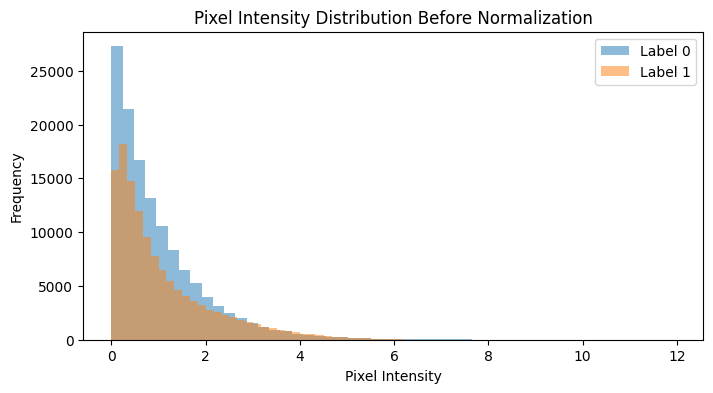

In [74]:

# Plot histogram
def plot_pixel_intensity_distribution(images, labels, title="Pixel Intensity Distribution"):
    # Flatten pixel values for both classes
    pixel_values_0 = images[labels == 0].flatten()
    pixel_values_1 = images[labels == 1].flatten()

    # Create histogram plot
    plt.figure(figsize=(8, 4))
    plt.hist(pixel_values_0, bins=50, alpha=0.5, label="Label 0")
    plt.hist(pixel_values_1, bins=50, alpha=0.5, label="Label 1")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.show()

plot_pixel_intensity_distribution(images, labels, "Pixel Intensity Distribution Before Normalization")




### Observations
- The majority of pixels(for both Label 0 and Label 1) have low intensity(close to 0)
- Data Labelled 1 has a higher spread indicating that images with label 1 contain **brighter pixels**
- The pixel brightness rarely exceeds 4 which indicates that bright pixels are relatively uncommon
- There is a **long tail towards higher intensities**, but very few pixels have intensity above **8**


In [75]:
pixel_values_0 = images[labels == 0].flatten()
pixel_values_1 = images[labels == 1].flatten()

print(f"Maximum pixel intensity of Label 0 is {max(pixel_values_0)}")
print(f"Maximum pixel intensity of Label 1 is {max(pixel_values_1)}")

Maximum pixel intensity of Label 0 is 11.959763499698632
Maximum pixel intensity of Label 1 is 8.35401311490326


Another interesting observation I see is that the maximum value of Label 0 data is more than that of Label 1 data which indicates the presence of some outliers

In [70]:
print(f"Max pixel in Label 0: {np.max(pixel_values_0)}")
print(f"Max pixel in Label 1: {np.max(pixel_values_1)}")
print(f"99th percentile of Label 0: {np.percentile(pixel_values_0, 99)}")
print(f"99th percentile of Label 1: {np.percentile(pixel_values_1, 99)}")

Max pixel in Label 0: 11.959763499698632
Max pixel in Label 1: 8.35401311490326
99th percentile of Label 0: 4.6223081187058765
99th percentile of Label 1: 4.649658310778583


## Outlier Detection in Pixel Intensities

### **Key Findings**
- The **maximum pixel intensity in Label 0** is **11.96**, which is higher than **Label 1** (8.35).
- However, the **99th percentile for both Label 0 and Label 1 is around ~4.6**, meaning that **most pixel values are below this threshold**.
- This indicates that **the high values in Label 0 are outliers** rather than a normal characteristic of the class.

### **Interpretation**
- The **majority of pixel intensities are within the 0 to 4.6 range**, but Label 0 has **a few extreme bright pixels** that might be due to **noise or artifacts**.
- Since **outliers in Label 0** could affect model training, we should consider **normalization strategies** to prevent the model from learning incorrect features.

### Next Steps

Now I would normalise the data but instead of normalising using the maximum value we can normalise using the 99th percentile

In [ ]:
# Apply Percentile Normalization (Using 99th Percentile)
percentile_99 = np.percentile(images, 99)
images_normalized = images / percentile_99  # Scale pixel values using 99th percentile

# Verify normalization
print(f"New Min: {np.min(images_normalized)}, New Max: {np.max(images_normalized)}")

New Min: 1.85142888272182e-07, New Max: 2.577302055768138


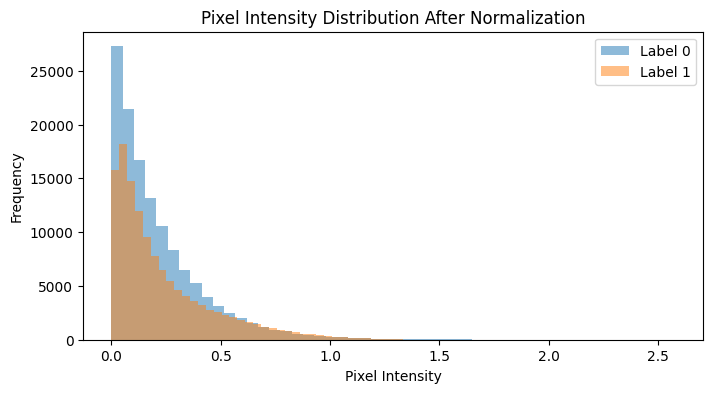

In [77]:
plot_pixel_intensity_distribution(images_normalized, labels, "Pixel Intensity Distribution After Normalization")


### Observations
- The **new pixel intensity range** is from **~0 to ~2.57** instead of **0 to 12**.
- The histogram after normalization **preserves the overall shape** while preventing outliers from dominating.
- Label 0 and Label 1 still show **different intensity distributions**, meaning pixel intensity remains a useful feature for classification.

## Summary of Exploratory Data Analysis (EDA)

- **Key Differences Between Label 0 and Label 1**:
  - **Label 0**: Appears noisy, has mostly **low-intensity pixels**, no clear structure.
  - **Label 1**: Contains **brighter regions**, possibly representing **galaxies or light sources**.
- **Brightness is a useful feature**:
  - **Histogram shows** that Label 1 images **contain more bright pixels** compared to Label 0.
- **Outliers Detected**:
  - Label 0 had a **maximum pixel intensity of 11.96**, while Label 1 was 8.35.
  - Since the **99th percentile was ~4.6**, we applied **percentile normalization** to handle outliers.
- **Next Steps**:
  - Evaluate the provided model’s performance on the **normalized dataset**.
  - Check if the model is **learning correctly** and analyze its **classification results**.